# Projections onto null space


Created by Diana L. Giraldo, Dec 2024

Last modification: Dec 2024

In [1]:
import os,sys
import numpy as np
import nibabel as nib

import torch
import torch.nn as nn

In [2]:
cwd_path = os.getcwd()
print("Working directory:", cwd_path)

Working directory: /home/vlab/null_space_projections


In [3]:
sys.path.insert(0,cwd_path)
from utils.plots import show_orthoslices
from utils.blurring_downsampling import BlurringDownsampling
from utils.null_projections import wilson_barret

## Load image x

In [4]:
img_fpath = os.path.join(cwd_path, 'demo_data', 'synth_HR_T1.nii.gz')

Input image: /home/vlab/null_space_projections/demo_data/synth_HR_T1.nii.gz
Image array shape: [156 186 168]
Voxel size: [1. 1. 1.]
Orientation of voxel axes: ('R', 'A', 'S')


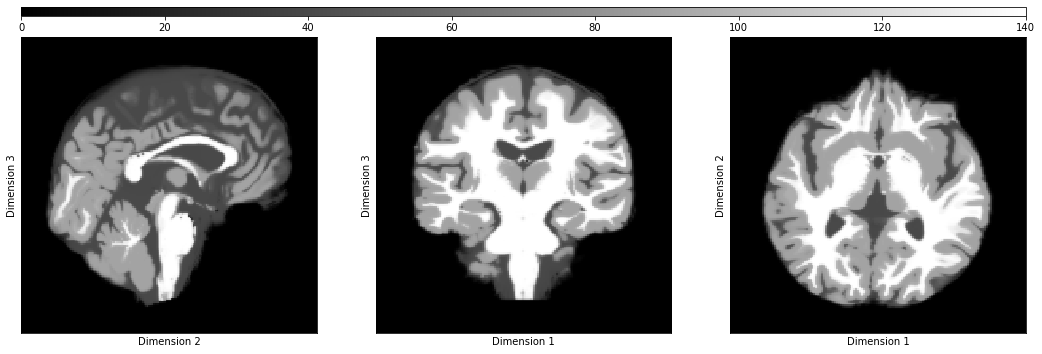

In [5]:
IMG = nib.load(img_fpath)
IMG_dim = IMG.header['dim'][1:4]
print('Input image:', img_fpath)
print('Image array shape:', IMG_dim)
print('Voxel size:', IMG.header['pixdim'][1:4])
print('Orientation of voxel axes:', nib.aff2axcodes(IMG.affine))

IMG_maxint = np.max(IMG.get_fdata())
IMG_cross = np.round(np.array(IMG_dim)/2).astype(np.int32)
show_orthoslices(IMG.get_fdata(), IMG_cross)
IMG.uncache()

In [6]:
x = torch.from_numpy(IMG.get_fdata()).float().unsqueeze(0).unsqueeze(0)

## Imaging model M

Blurring and downsampling as a strided convolution.

In [7]:
slice_thickness = 5
slice_spacing = 6

In [8]:
M = BlurringDownsampling(
    slice_thickness, 
    slice_spacing, 
    dimension='3d',
    slice_model = "smoothed-box",
    normalize_kernel = True,
)

### Forward operator

In [9]:
y = M(x)

[78 93 14]


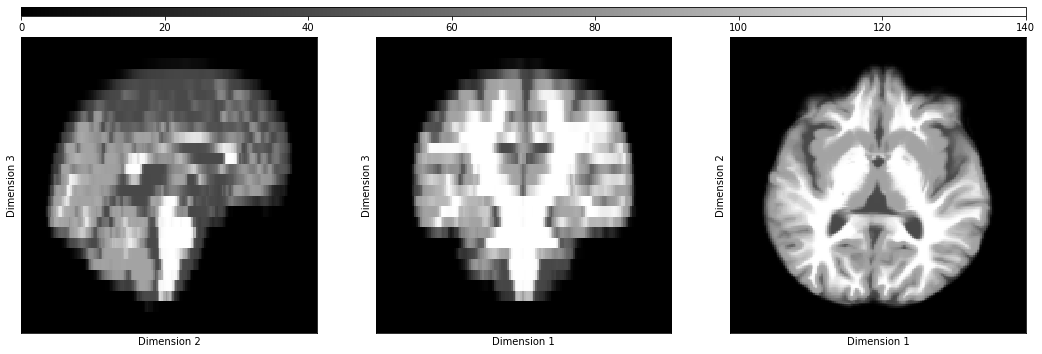

In [10]:
y_cross = np.copy(IMG_cross)
y_cross[2] = (IMG_cross[2]/slice_spacing).astype(np.int32)
print(y_cross)

show_orthoslices(y.numpy().squeeze(), y_cross)

## Projections of x onto Null and Measurement space

In [11]:
# Parameter for numerical projection onto H null space
alpha = 2 # step size between 1 and 2 seems to work but it depends on M

In [12]:
x_null = wilson_barret(
    M, 
    x, 
    step = alpha, 
    tolerance = 0.01, 
    max_iter = 40,
    print_info = True,
)

tensor(42348.6797)
tensor(26521.8750)
tensor(16609.8457)
tensor(10402.3340)
tensor(6514.6938)
tensor(4079.9714)
tensor(2555.1829)
tensor(1600.2411)
tensor(1002.1904)
tensor(627.6442)
tensor(393.0786)
tensor(246.1756)
tensor(154.1733)
tensor(96.5551)
tensor(60.4703)
tensor(37.8712)
tensor(23.7179)
tensor(14.8540)
tensor(9.3027)
tensor(5.8261)
tensor(3.6487)
tensor(2.2851)
tensor(1.4311)
tensor(0.8963)
tensor(0.5613)
tensor(0.3515)
tensor(0.2202)
tensor(0.1379)
tensor(0.0864)
tensor(0.0541)
tensor(0.0339)
tensor(0.0212)
tensor(0.0133)
tensor(0.0084)


In [13]:
x_meas = x - x_null

x projected onto Measurement space:


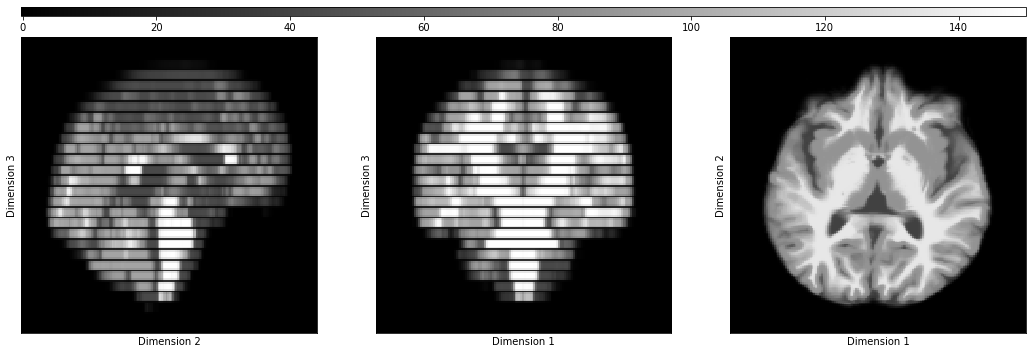

x projected onto Null space:


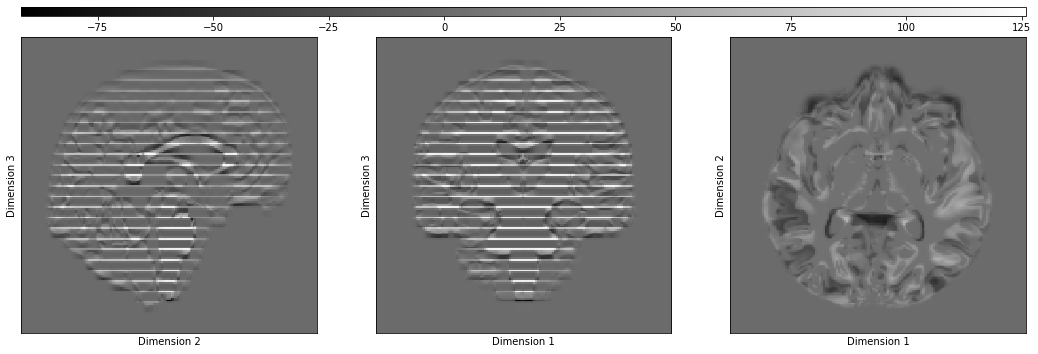

In [14]:
print("x projected onto Measurement space:")
show_orthoslices(x_meas.numpy().squeeze(), IMG_cross)

print("x projected onto Null space:")
show_orthoslices(x_null.numpy().squeeze(), IMG_cross)

## Projections of reconstructions onto Null and Measurement space

### Trilinear interpolation

In [15]:
# trilinear interpolation
interp_x = nn.functional.interpolate(y, size = tuple(IMG_dim), mode = 'trilinear', align_corners=True)

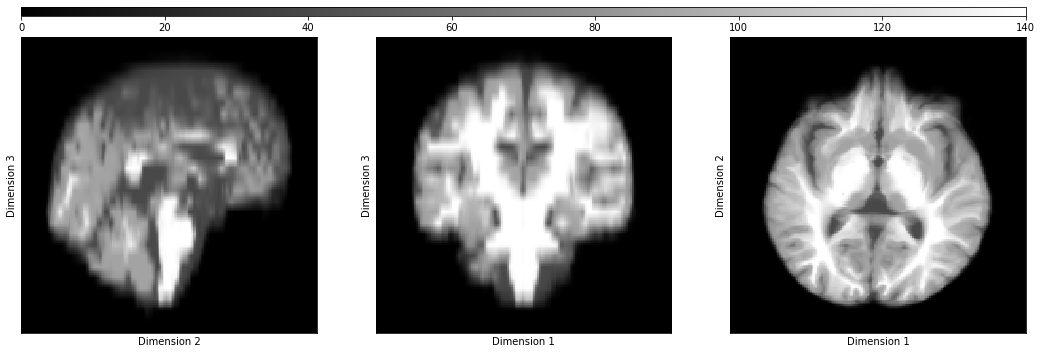

In [18]:
show_orthoslices(interp_x.numpy().squeeze(), IMG_cross)

In [19]:
interp_x_null = wilson_barret(
    M, 
    interp_x, 
    step = alpha, 
    tolerance = 0.01, 
    max_iter = 40,
    print_info = False,
)
interp_x_meas = interp_x - interp_x_null

Interpolation projected onto Measurement space:


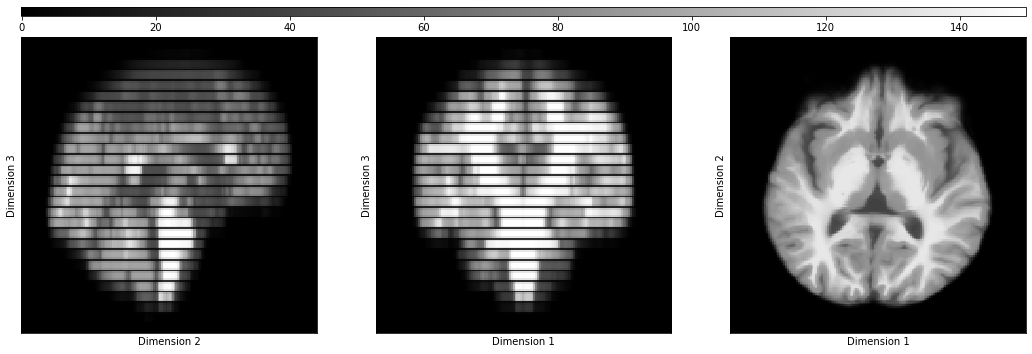

Interpolation projected onto Null space:


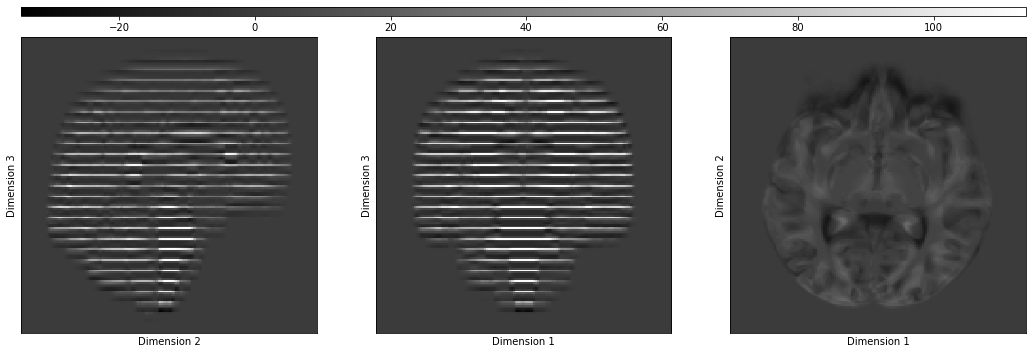

In [20]:
print("Interpolation projected onto Measurement space:")
show_orthoslices(interp_x_meas.numpy().squeeze(), IMG_cross)

print("Interpolation projected onto Null space:")
show_orthoslices(interp_x_null.numpy().squeeze(), IMG_cross)

### PRETTIER MRI

In [21]:
# PRETTIER 
PRETTIER_REC = nib.load(os.path.join(cwd_path, 'demo_data', 'prettierEDSR_synth.nii.gz'))
prettier_x = torch.from_numpy(PRETTIER_REC.get_fdata()).float().unsqueeze(0).unsqueeze(0)

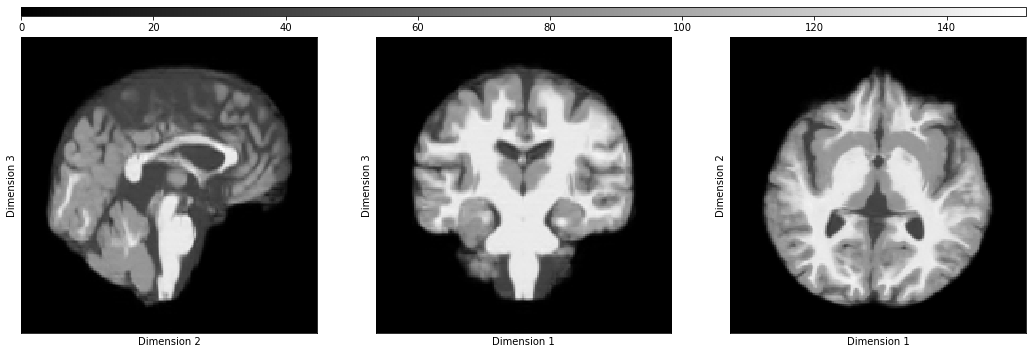

In [22]:
show_orthoslices(prettier_x.numpy().squeeze(), IMG_cross)

In [23]:
prettier_x_null = wilson_barret(
    M, 
    prettier_x, 
    step = alpha, 
    tolerance = 0.01, 
    max_iter = 40,
    print_info = False,
)
prettier_x_meas = prettier_x - prettier_x_null

PRETTIER projected onto Measurement space:


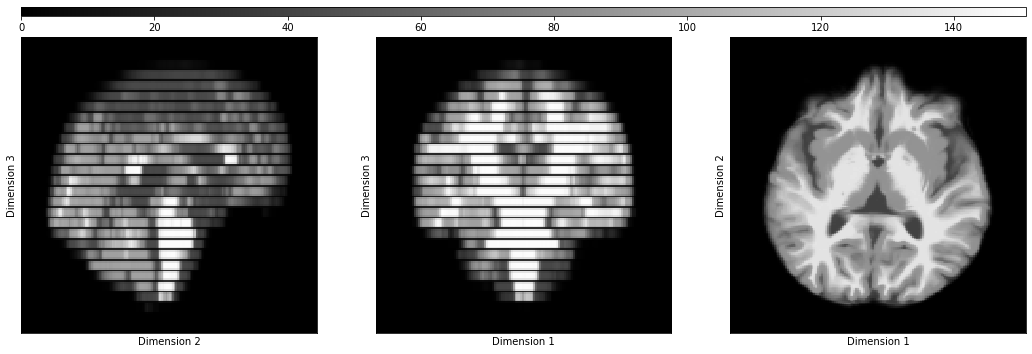

PRETTIER projected onto Null space:


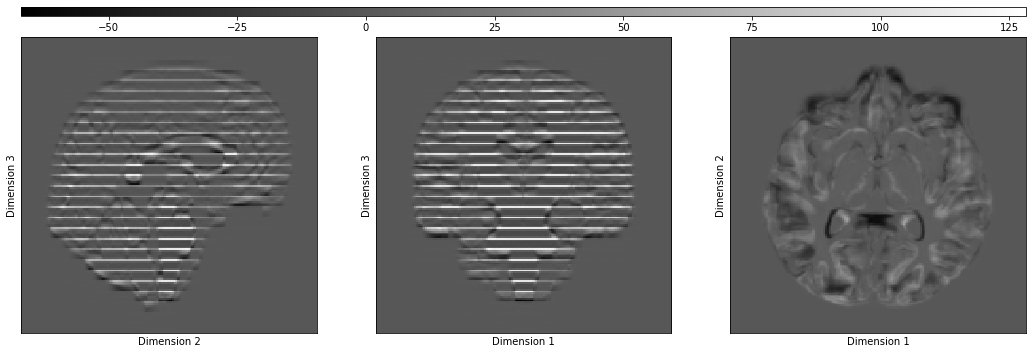

In [24]:
print("PRETTIER projected onto Measurement space:")
show_orthoslices(prettier_x_meas.numpy().squeeze(), IMG_cross)

print("PRETTIER projected onto Null space:")
show_orthoslices(prettier_x_null.numpy().squeeze(), IMG_cross)

## Hallucination map in Null space

**Hallucination map**: Difference in the reconstructed null component, what the reconstruction method is making up.

In [25]:
interp_hm_null = (interp_x_null != 0)*(interp_x_null - x_null)
prettier_hm_null = (prettier_x_null != 0)*(prettier_x_null - x_null)

Hallucination map in null space for interpolation:


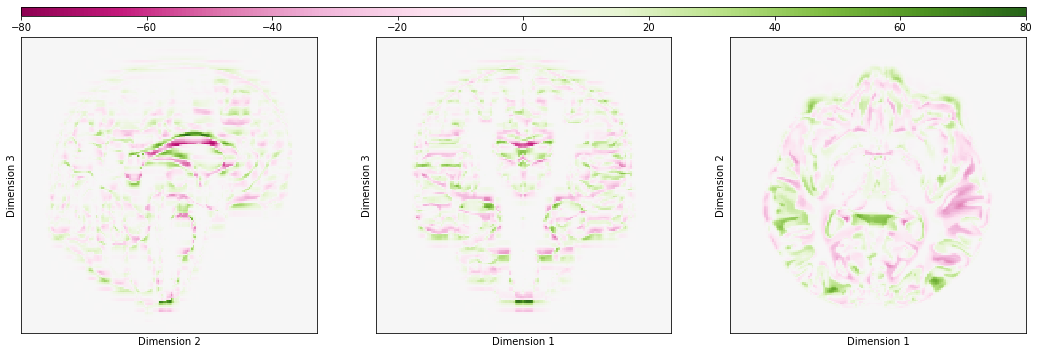

Hallucination map in null space for PRETTIER:


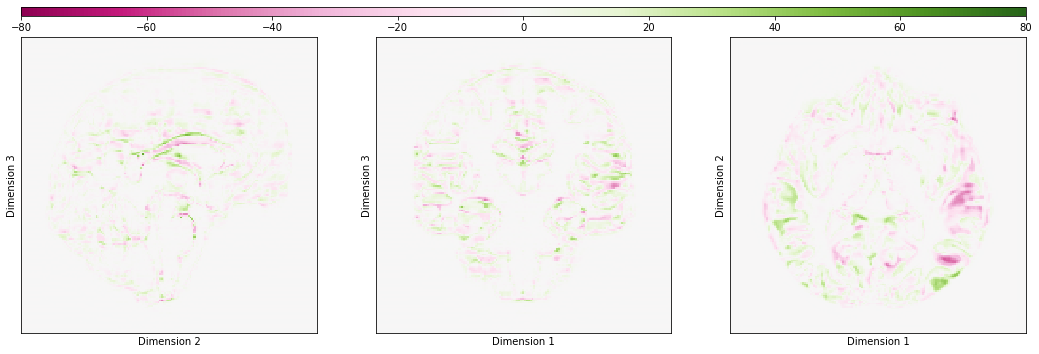

In [27]:
print("Hallucination map in null space for interpolation:")
show_orthoslices(interp_hm_null.numpy().squeeze(), IMG_cross, cmap = "PiYG", vmin = -80, vmax = 80)

print("Hallucination map in null space for PRETTIER:")
show_orthoslices(prettier_hm_null.numpy().squeeze(), IMG_cross, cmap = "PiYG", vmin = -80, vmax = 80)